In [2]:
import pandas as pd
import os
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch.utils.data as data

from settings import INPUTS_PATH
from utils.data_utils import timeseries_train_test_split, create_rolling_window_ts

plt.style.use('ggplot')

In [3]:
df = pd.read_csv(os.path.join(INPUTS_PATH, 'mixed_freq_df.csv'))
df.set_index('date', inplace=True)

df.tail()

,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
date,,,,,,,,,,,,,
2021-08-01,0.003286,NaN,0.002744,-0.037037,0.007042,-0.001632,-0.001062,0.001018,0.003135,0.003824,0.055828,NaN,NaN
2021-09-01,0.002570,0.005709,0.004124,-0.096154,-0.014622,-0.009759,-0.016185,0.002431,0.002405,0.003465,-0.078443,0.023111,0.014297
2021-10-01,0.004383,NaN,0.009433,-0.021277,0.001290,0.012333,-0.001650,0.005992,0.004427,0.006487,0.042245,NaN,NaN
2021-11-01,0.001677,NaN,0.007791,-0.086957,0.081186,0.007375,-0.001950,0.005346,0.004803,0.006266,0.038717,NaN,NaN
2021-12-01,0.001338,0.016791,0.004705,-0.071429,0.014303,-0.001024,-0.002285,0.005501,0.004981,0.004476,0.097845,NaN,NaN


## RNN with Univariate Time Series

### Dataset

<Axes: xlabel='date'>

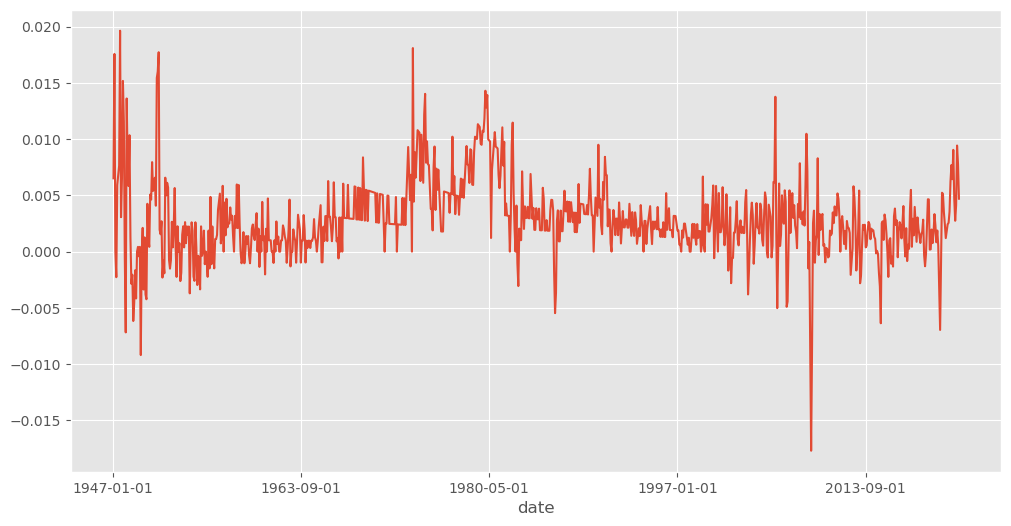

In [4]:
y = df["cpiaucsl"]

y.plot(figsize=(12, 6))

### RNN offline

In [5]:
class RNN1(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 num_layers: int,
                 batch_first: bool=True) -> None:
        super().__init__()

        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=batch_first,
                          bias=True)
        self.linear = nn.Linear(in_features=hidden_size,
                                out_features=input_size,
                                bias=False)

    def forward(self,
                x: torch.Tensor,
                h0: torch.Tensor=None) -> torch.Tensor:
         # forward pass
        o_t, _ = self.rnn(x, h0)

        # apply output to linear layer
        o_t = self.linear(o_t)

        return o_t, _
    
input_size = 1
hidden_size = 50
num_layers = 1
batch_first = True
fix_start = False
learning_rate = 0.01
train_ratio = 0.8
epochs = 2000

num_timesteps_in = 12
num_timesteps_out = 1
train_shuffle = False
batch_size = 1
drop_last = True

target_df = df[["cpiaucsl"]].dropna()

# dim: [num_batches, seq_len, input_size]
y_tensor = torch.tensor(target_df.to_numpy()).to(torch.float32)
train_size = int(train_ratio * y_tensor.shape[0])
T = y_tensor.shape[0]

X_train, X_test, y_train, y_test = timeseries_train_test_split(X=y_tensor,
                                                                y=y_tensor,
                                                                train_ratio=train_ratio)

X_train, y_train = create_rolling_window_ts(target=y_train,
                                            features=X_train,
                                            num_timesteps_in=num_timesteps_in,
                                            num_timesteps_out=num_timesteps_out,
                                            fix_start=fix_start,
                                            drop_last=drop_last)

X_test, y_test = create_rolling_window_ts(target=y_test,
                                            features=X_test,
                                            num_timesteps_in=num_timesteps_in,
                                            num_timesteps_out=num_timesteps_out,
                                            fix_start=fix_start,
                                            drop_last=False)

train_loader = data.DataLoader(data.TensorDataset(X_train, y_train),
                                shuffle=train_shuffle,
                                batch_size=batch_size,
                                drop_last=drop_last)

In [9]:
# model setup
model1 = RNN1(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first)

# loss function
loss_fn = nn.MSELoss()

# optimizer
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)

h_t = torch.zeros(num_layers, batch_size, hidden_size)
for i in tqdm(range(epochs), total=epochs, desc='Training RNN1'):
    for X_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()

        y_pred, h_t = model1(X_train_batch, h0=h_t)
        h_t = h_t.detach() 

        loss = loss_fn(y_pred, y_train_batch)
        loss.backward()
        optimizer.step()
    
    model1.eval()
    with torch.no_grad():

        # NOTE - workaround for batch size = 1
        max_batch_size = X_test.size(0) if batch_first else X_test.size(1)
        h_t = h_t.repeat(num_layers, max_batch_size, 1)
        y_pred, h_t = model1(X_test, h_t)
        h_t = h_t.detach()[:, -1:, :]

        test_loss = loss_fn(y_pred, y_test)
        

Training RNN1: 100%|██████████| 2000/2000 [14:59<00:00,  2.22it/s]


In [10]:
with torch.no_grad():
    y_pred_train, _ = model1(X_train)
    y_pred_test, _ = model1(X_test)

    train_pred_df = pd.DataFrame(y_pred_train[:, -1, :].detach().numpy(), columns=["preds"], index=target_df.index[num_timesteps_in+1:train_size])
    test_pred_df = pd.DataFrame(y_pred_test[:, -1, :].detach().numpy(), columns=["preds"], index=target_df.index[(train_size + num_timesteps_in):T])
    pred_df = pd.concat([train_pred_df, test_pred_df], axis=0)

    pred_df = pd.concat([target_df.iloc[num_timesteps_in+1:, ], pred_df], axis=1)
    pred_df.index = pd.to_datetime(pred_df.index)

Text(0.5, 1.0, 'CPI vs Predicted CPI')

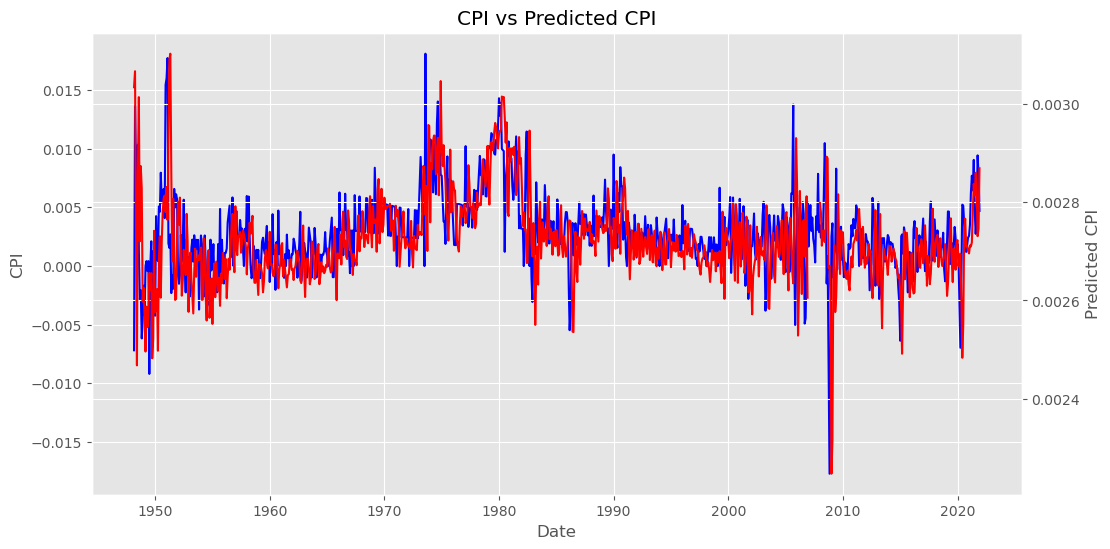

In [11]:
# two y-axes plot and shared x-axis
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(pred_df["cpiaucsl"], color="blue")
ax2.plot(pred_df["preds"], color="red")
ax1.set_ylabel("CPI")
ax2.set_ylabel("Predicted CPI")
ax1.set_xlabel("Date")
plt.title("CPI vs Predicted CPI")